Step 1: Import Required Libraries and Load Data

In [19]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
import re
from sklearn.utils import resample

# Load the cleaned SpaceX dataset
df = pd.read_csv("spacex_clean_data.csv")
df.head()

,flight_no.,date_and_time_(utc),"version,_booster[h]",launch_site,payload[i],payload_mass,orbit,customer,launch_outcome,booster_landing
0,195,"January 3, 2023 14:56[17]",F9 B5 B1060‑15,"Cape Canaveral, SLC‑40",Transporter-6 (115 payload smallsat rideshare),Unknown[j],SSO,Various,Success,Success (LZ‑1)
1,195,Dedicated SmallSat Rideshare mission to Sun-sy...,Dedicated SmallSat Rideshare mission to Sun-sy...,Dedicated SmallSat Rideshare mission to Sun-sy...,Dedicated SmallSat Rideshare mission to Sun-sy...,Dedicated SmallSat Rideshare mission to Sun-sy...,Dedicated SmallSat Rideshare mission to Sun-sy...,Dedicated SmallSat Rideshare mission to Sun-sy...,Dedicated SmallSat Rideshare mission to Sun-sy...,Dedicated SmallSat Rideshare mission to Sun-sy...
2,196,"January 10, 2023 04:50[23]",F9 B5 B1076‑2,"Cape Canaveral, SLC‑40",OneWeb 16 (40 satellites),"6,000 kg (13,000 lb)",Polar LEO,OneWeb,Success,Success (LZ‑1)
3,196,"Following the Russian invasion of Ukraine, One...","Following the Russian invasion of Ukraine, One...","Following the Russian invasion of Ukraine, One...","Following the Russian invasion of Ukraine, One...","Following the Russian invasion of Ukraine, One...","Following the Russian invasion of Ukraine, One...","Following the Russian invasion of Ukraine, One...","Following the Russian invasion of Ukraine, One...","Following the Russian invasion of Ukraine, One..."
4,FH 5,"January 15, 2023 22:56[29]",Falcon Heavy B5 B1070 (core),"Kennedy, LC‑39A",USSF-67 (CBAS-2 & LDPE-3A),"~3,750 kg (8,270 lb)",GEO,USSF,Success,No attempt


## Step 2: Data Preprocessing

In [20]:
# Step 1: Convert and clean payload mass
def extract_kg(payload):
    match = re.search(r"([\d,]+)\s*kg", str(payload))
    if match:
        return float(match.group(1).replace(',', ''))
    return None

df['payload_mass_kg'] = df['payload_mass'].apply(extract_kg)

# Step 2: Convert launch outcome to binary success
df['success'] = df['launch_outcome'].map({'Success': 1, 'Failure': 0})

# Step 3: Select and clean required columns
df_model = df[['payload_mass_kg', 'success', 'launch_site', 'version,_booster[h]']].copy()
df_model.dropna(inplace=True)

# Step 4: One-hot encode categorical variables
df_model = pd.get_dummies(df_model, columns=['launch_site', 'version,_booster[h]'], drop_first=True)

# Step 5: Separate majority and minority classes
df_majority = df_model[df_model['success'] == 1]
df_minority = df_model[df_model['success'] == 0]

# Step 6: Oversample minority class
df_minority_upsampled = resample(df_minority,replace=True,n_samples=len(df_majority),random_state=42)     

# Step 7: Combine majority and upsampled minority
df_balanced = pd.concat([df_majority, df_minority_upsampled])

# Step 8: Split into features and labels
X = df_balanced.drop('success', axis=1)
y = df_balanced['success']

# Step 9: Scale features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Step 10: Train-test split
X_train, X_test, y_train, y_test = train_test_split(
    X_scaled, y, test_size=0.3, random_state=42, stratify=y)

# Step 11: Print class distributions
print("Train set class distribution:")
print(y_train.value_counts())
print("\nTest set class distribution:")
print(y_test.value_counts())


Train set class distribution:
success
1.0    213
0.0    212
Name: count, dtype: int64

Test set class distribution:
success
0.0    92
1.0    91
Name: count, dtype: int64


## Step 3: Train and Evaluate Multiple Models

In [21]:
models = {
    "Logistic Regression": LogisticRegression(),
    "Decision Tree": DecisionTreeClassifier(),
    "Support Vector Machine": SVC(),
    "Random Forest": RandomForestClassifier()
}

results = {}
conf_matrices = {}

for name, model in models.items():
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    acc = accuracy_score(y_test, y_pred)
    cm = confusion_matrix(y_test, y_pred)
    results[name] = acc
    conf_matrices[name] = cm
    print(f"\n{name} Accuracy: {acc:.4f}")
    print(classification_report(y_test, y_pred))



Logistic Regression Accuracy: 0.8962
              precision    recall  f1-score   support

         0.0       0.83      1.00      0.91        92
         1.0       1.00      0.79      0.88        91

    accuracy                           0.90       183
   macro avg       0.91      0.90      0.89       183
weighted avg       0.91      0.90      0.89       183


Decision Tree Accuracy: 1.0000
              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00        92
         1.0       1.00      1.00      1.00        91

    accuracy                           1.00       183
   macro avg       1.00      1.00      1.00       183
weighted avg       1.00      1.00      1.00       183


Support Vector Machine Accuracy: 1.0000
              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00        92
         1.0       1.00      1.00      1.00        91

    accuracy                           1.00       183
   macro avg     

## Step 4: Plot Model Accuracy Comparison

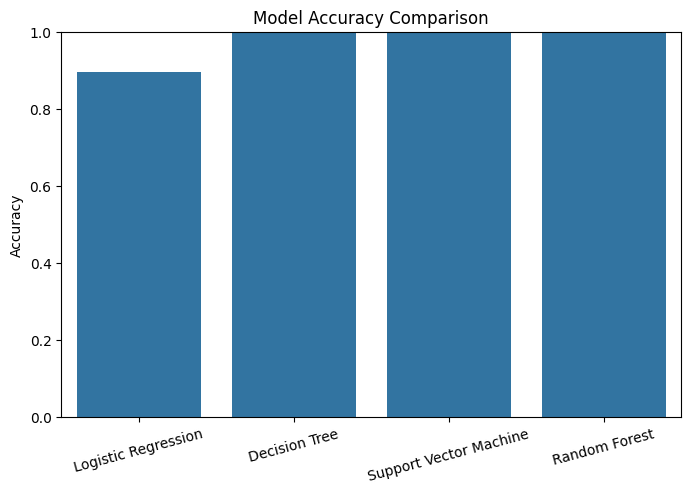

In [22]:
plt.figure(figsize=(8,5))
sns.barplot(x=list(results.keys()), y=list(results.values()))
plt.ylabel("Accuracy")
plt.title("Model Accuracy Comparison")
plt.ylim(0, 1)
plt.xticks(rotation=15)
plt.show()


## Step 5: Show Confusion Matrix for Best Model

Best Model: Decision Tree


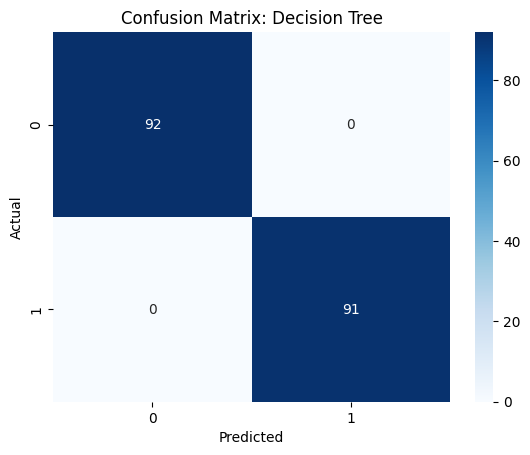

In [23]:
best_model = max(results, key=results.get)
print(f"Best Model: {best_model}")
sns.heatmap(conf_matrices[best_model], annot=True, fmt='d', cmap='Blues')
plt.title(f"Confusion Matrix: {best_model}")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()
